In [127]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

import umap

from collections import Counter

import spacy

# load files and make corpus

In [2]:
with open('hansard-speeches-post2010-lemmatized-agg.pkl', 'rb') as f:
    df = pickle.load(f)

In [3]:
with open('hansard-speeches-post2010.pkl', 'rb') as f:
    df_orig = pickle.load(f)

In [4]:
MP_party = df_orig[['display_as', 'party']]
MP_party = MP_party.drop_duplicates('display_as').set_index('display_as')

In [5]:
names = [x[2] for x in df.index.values]
parties = [MP_party.loc[MP_name].party for MP_name in names]

In [6]:
corpus = list(df.speech.values)
# corpus = list(df.lemmas.apply(lambda x: " ".join(x)).values)

# speech embedding

In [7]:
from sentence_transformers import SentenceTransformer

# embedder = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embedder = SentenceTransformer('paraphrase-mpnet-base-v2')
# embedder = SentenceTransformer('stsb-mpnet-base-v2') #75 max seq length

## count prop. contributions with word/lemma counts above embedder max input sequence length

max sequence length: 128
wordcounts above 128: 33.859 %
lemmacounts above 128: 22.3978 %


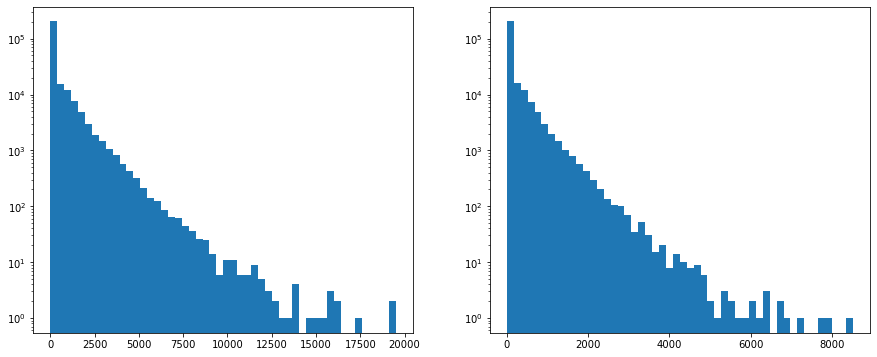

In [8]:
wordcount = df.speech.apply(lambda x: len(x.split())).values
lemmacount = df.lemmas.apply(len).values

max_seq_len = embedder.max_seq_length
print(f'max sequence length: {max_seq_len}')

fig, ax = plt.subplots(1,2,figsize=(15,6))

ax[0].hist(wordcount, bins=50)
ax[0].set_yscale('log')
print(f'wordcounts above {max_seq_len}: {np.around((np.sum(wordcount > max_seq_len) / len(wordcount))*100, 4)} %')

ax[1].hist(lemmacount, bins=50)
ax[1].set_yscale('log')
print(f'lemmacounts above {max_seq_len}: {np.around((np.sum(lemmacount > max_seq_len) / len(lemmacount))*100, 4)} %')

plt.show()

In [13]:
# don't run if loading embeddings
# corpus_embeddings = embedder.encode(corpus)
# corpus_embeddings = corpus_embeddings /  np.linalg.norm(corpus_embeddings, axis=1, keepdims=True)

In [9]:
# don't run if loading embeddings
# with open('corpus_embeddings.pkl', 'wb') as f:
#     pickle.dump(corpus_embeddings, f)

# run ito load embeddings
with open('corpus_embeddings.pkl', 'rb') as f:
    corpus_embeddings = pickle.load(f)

In [10]:
corpus_embeddings.shape

(253820, 768)

## PCA dimensionality reduction

In [11]:
from sklearn.decomposition import PCA
pca = PCA(random_state=26)
pca.fit(corpus_embeddings)

PCA(random_state=26)

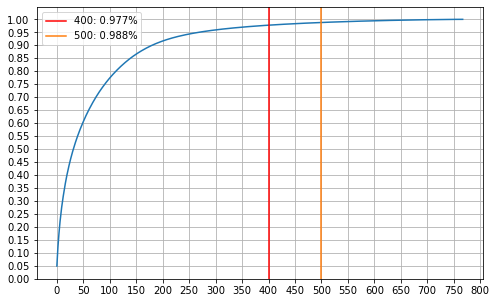

In [31]:
evr = pca.explained_variance_ratio_
cum_evr = [np.sum(evr[:i+1]) for i in range(len(evr))]



fig, ax = plt.subplots(figsize=(8,5))
ax.plot(cum_evr)
ax.grid()
ax.set_xticks(range(0,801,50))
ax.set_yticks(np.arange(0,1.05,0.05))

v = 400
ax.axvline(v, c='r', label=f'{v}: {np.around(cum_evr[v], 3)}%')

v = 500
ax.axvline(v, c='tab:orange', label=f'{v}: {np.around(cum_evr[v], 3)}%')

ax.legend()

plt.show()

In [32]:
# 400 dimensions corresponds to cumulative explained variance ratio of ~98%
embeddings = PCA(n_components=400, random_state=26).fit_transform(corpus_embeddings)

## umap dimensionality reduction

In [33]:
np.unique(parties)

array(['Alliance', 'Conservative', 'Democratic Unionist Party',
       'Green Party', 'Independent', 'Labour', 'Labour (Co-op)',
       'Liberal Democrat', 'Plaid Cymru', 'Respect',
       'Scottish National Party', 'Social Democratic & Labour Party',
       'Speaker', 'Ulster Unionist Party', 'nan'], dtype='<U32')

In [34]:
party_colormap = {
    'Alliance': '#F6CB2F',
    'Conservative': '#0087DC',
    'Democratic Unionist Party': '#D46A4C',
    'Green Party': '#6AB023',
    'Independent': '#DDDDDD',
    'Labour': '#E4003B',
    'Labour (Co-op)': '#E4003B',
    'Liberal Democrat': '#FAA61A',
    'Plaid Cymru': '#008142',
    'Scottish National Party': '#FDF38E',
    'Social Democratic & Labour Party': '#2AA82C',
    'Speaker': '#FFFFFF',
    'Respect': '#46801c',
    'Ulster Unionist Party': '#70147A',
    'nan': '#FFFFFF'
}

c = [party_colormap[str(x)] for x in parties]

In [40]:
# don't run if loading reduced embeddings
# reducer = umap.UMAP(n_neighbors=15, 
#                     min_dist=0,
#                     metric='cosine',
#                     low_memory=True)
# X = reducer.fit_transform(embeddings) # dimension reduced embedding

In [35]:
# don't run if loading reduced embeddings
# with open('umap_embeddings.pkl', 'wb') as f:
#     pickle.dump(X, f)

# run to load reduced embeddings
with open('umap_embeddings.pkl', 'rb') as f:
    X = pickle.load(f)

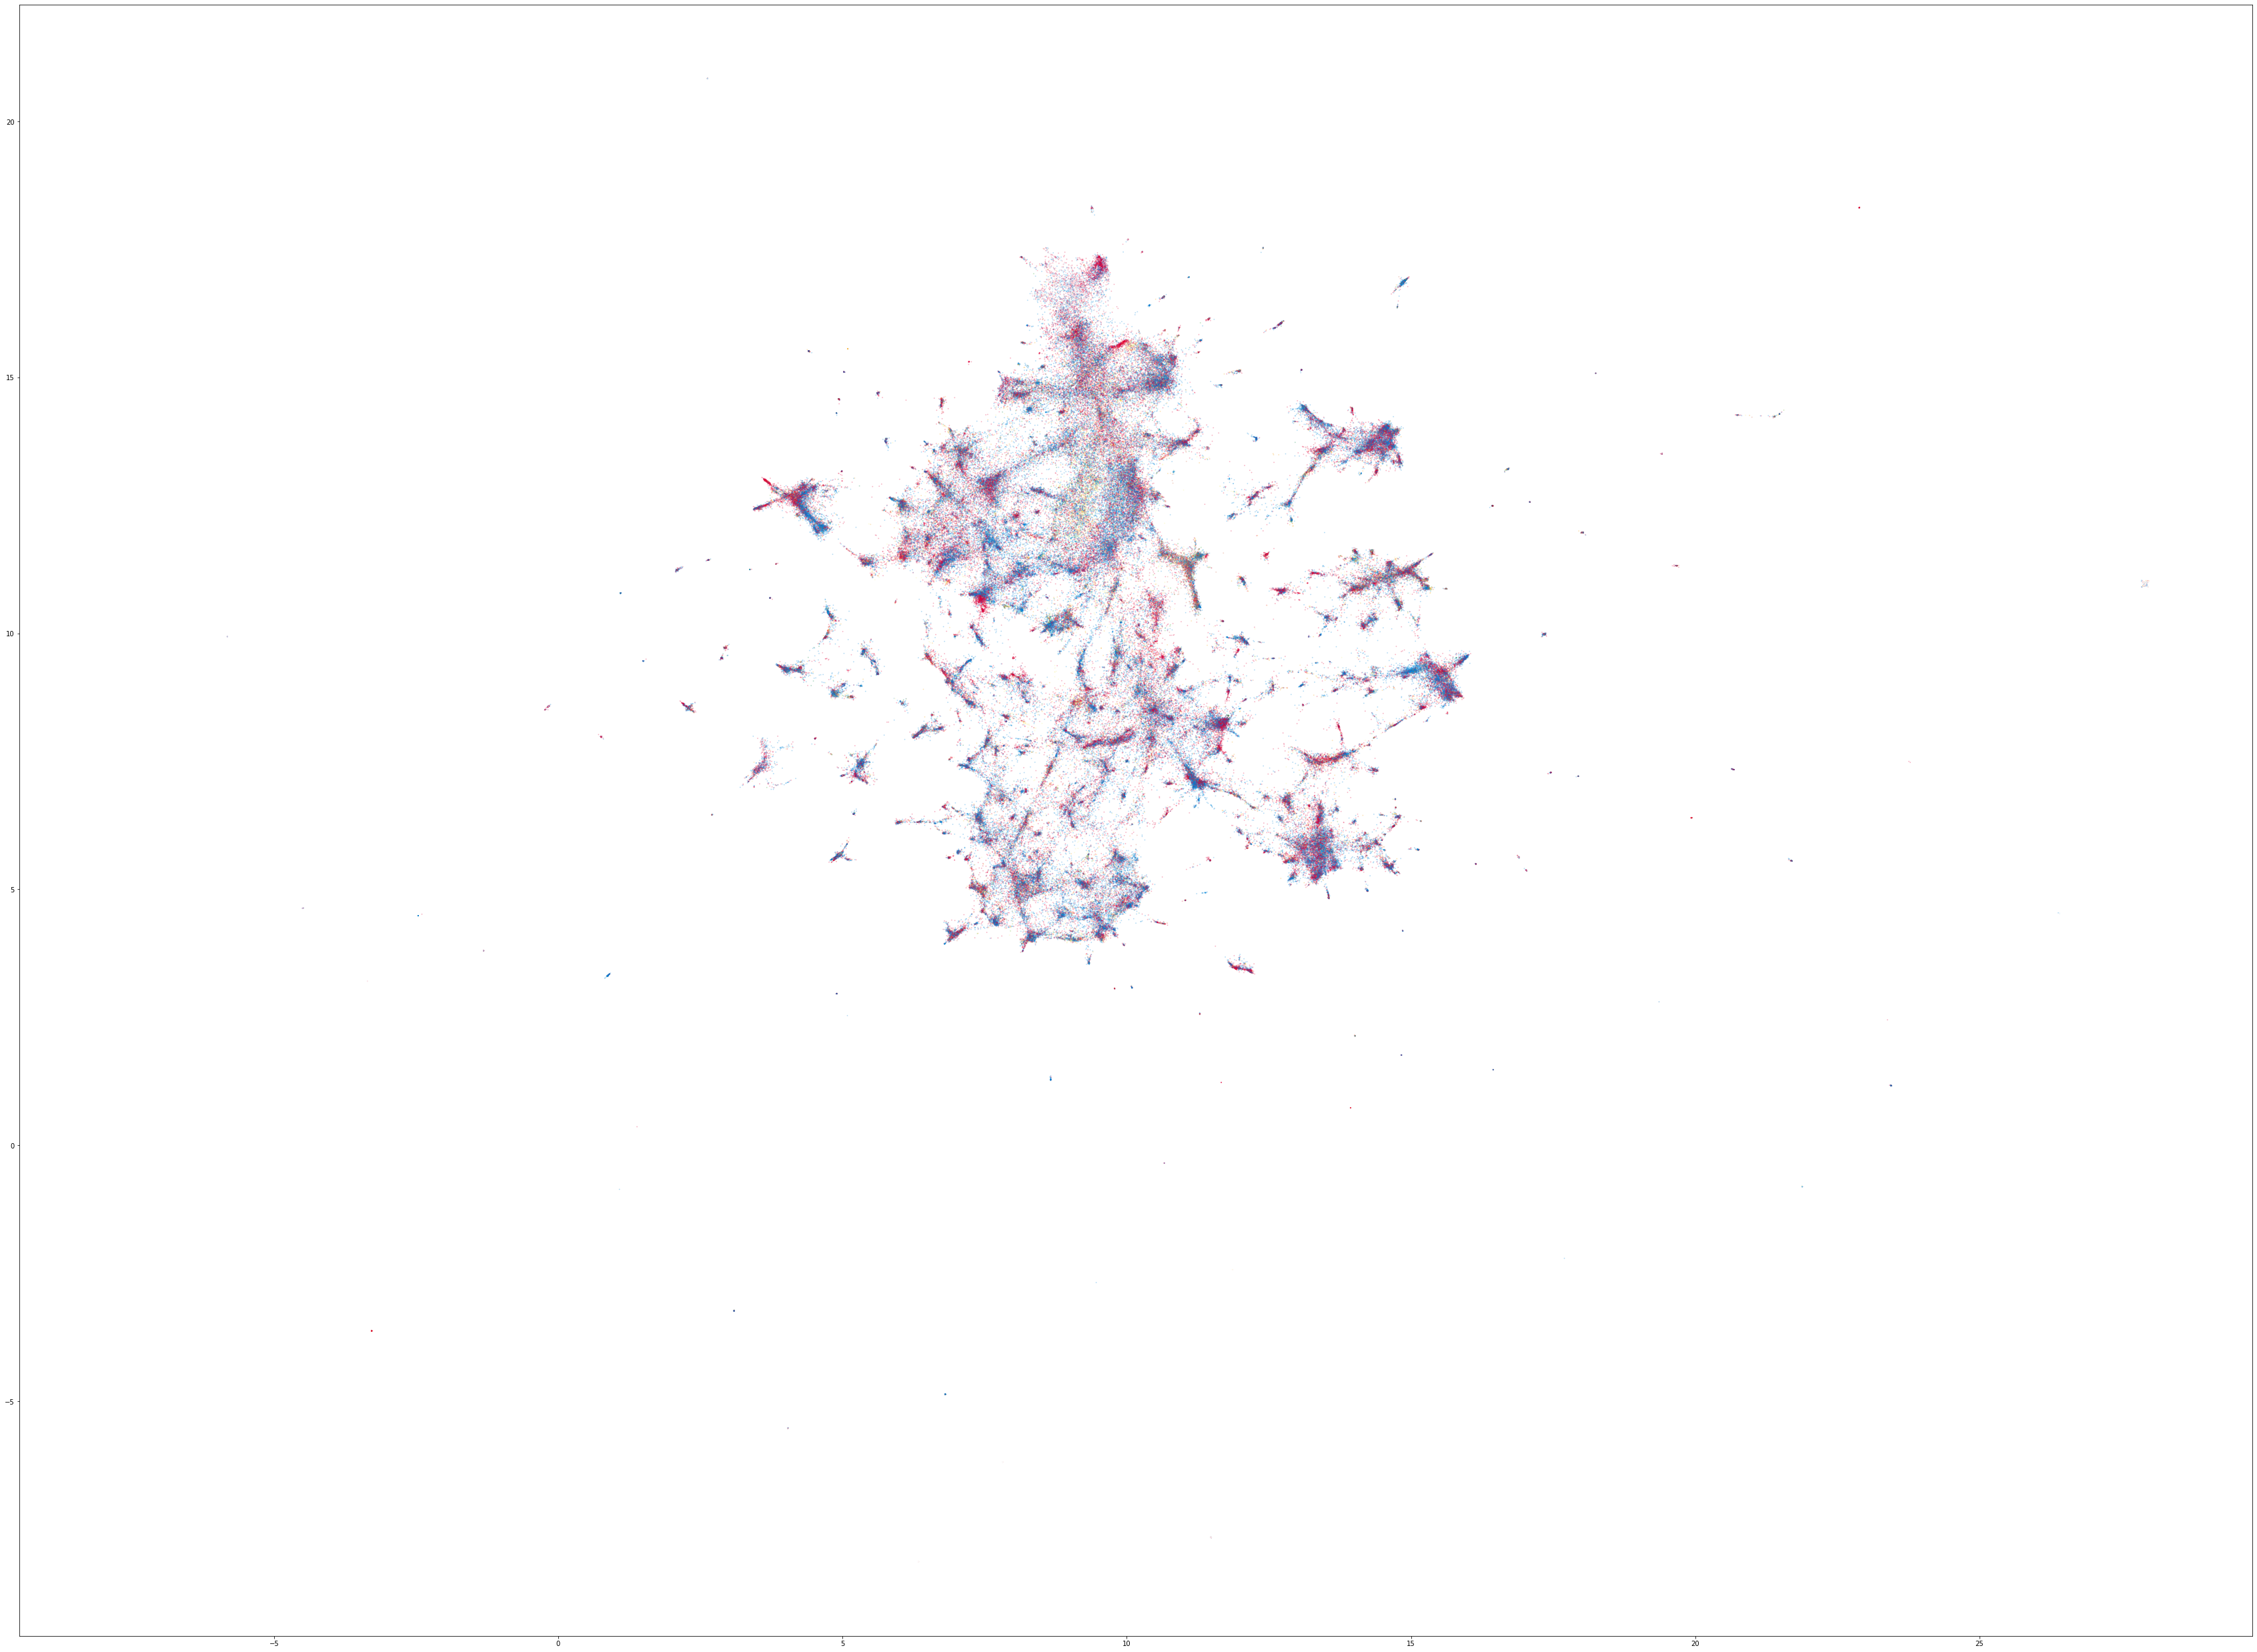

In [36]:
plt.figure(figsize=(60,45))
plt.scatter(X[:,0], X[:,1], s=1, alpha=.2, c=c)#, edgecolors='k', linewidth=0)
plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_2.png', dpi=150)
plt.show()

# clustering

In [306]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=20,
                            min_samples=25,
                            cluster_selection_epsilon=0.04,
                            cluster_selection_method='eom')

cluster_labels = clusterer.fit_predict(X)

In [307]:
label_map = np.random.choice(np.arange(len(np.unique(cluster_labels)) - 1), 
                             len(np.unique(cluster_labels)) - 1,
                             replace=False)
label_map = {o:n for o,n in zip(np.arange(len(label_map)), label_map)}
label_map[-1] = -1

cluster_labels = np.array([label_map[x] for x in cluster_labels])

<ipython-input-309-d2b489188668>:2: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("rainbow"))
  cmap.set_under('black')  # Color for values less than vmin


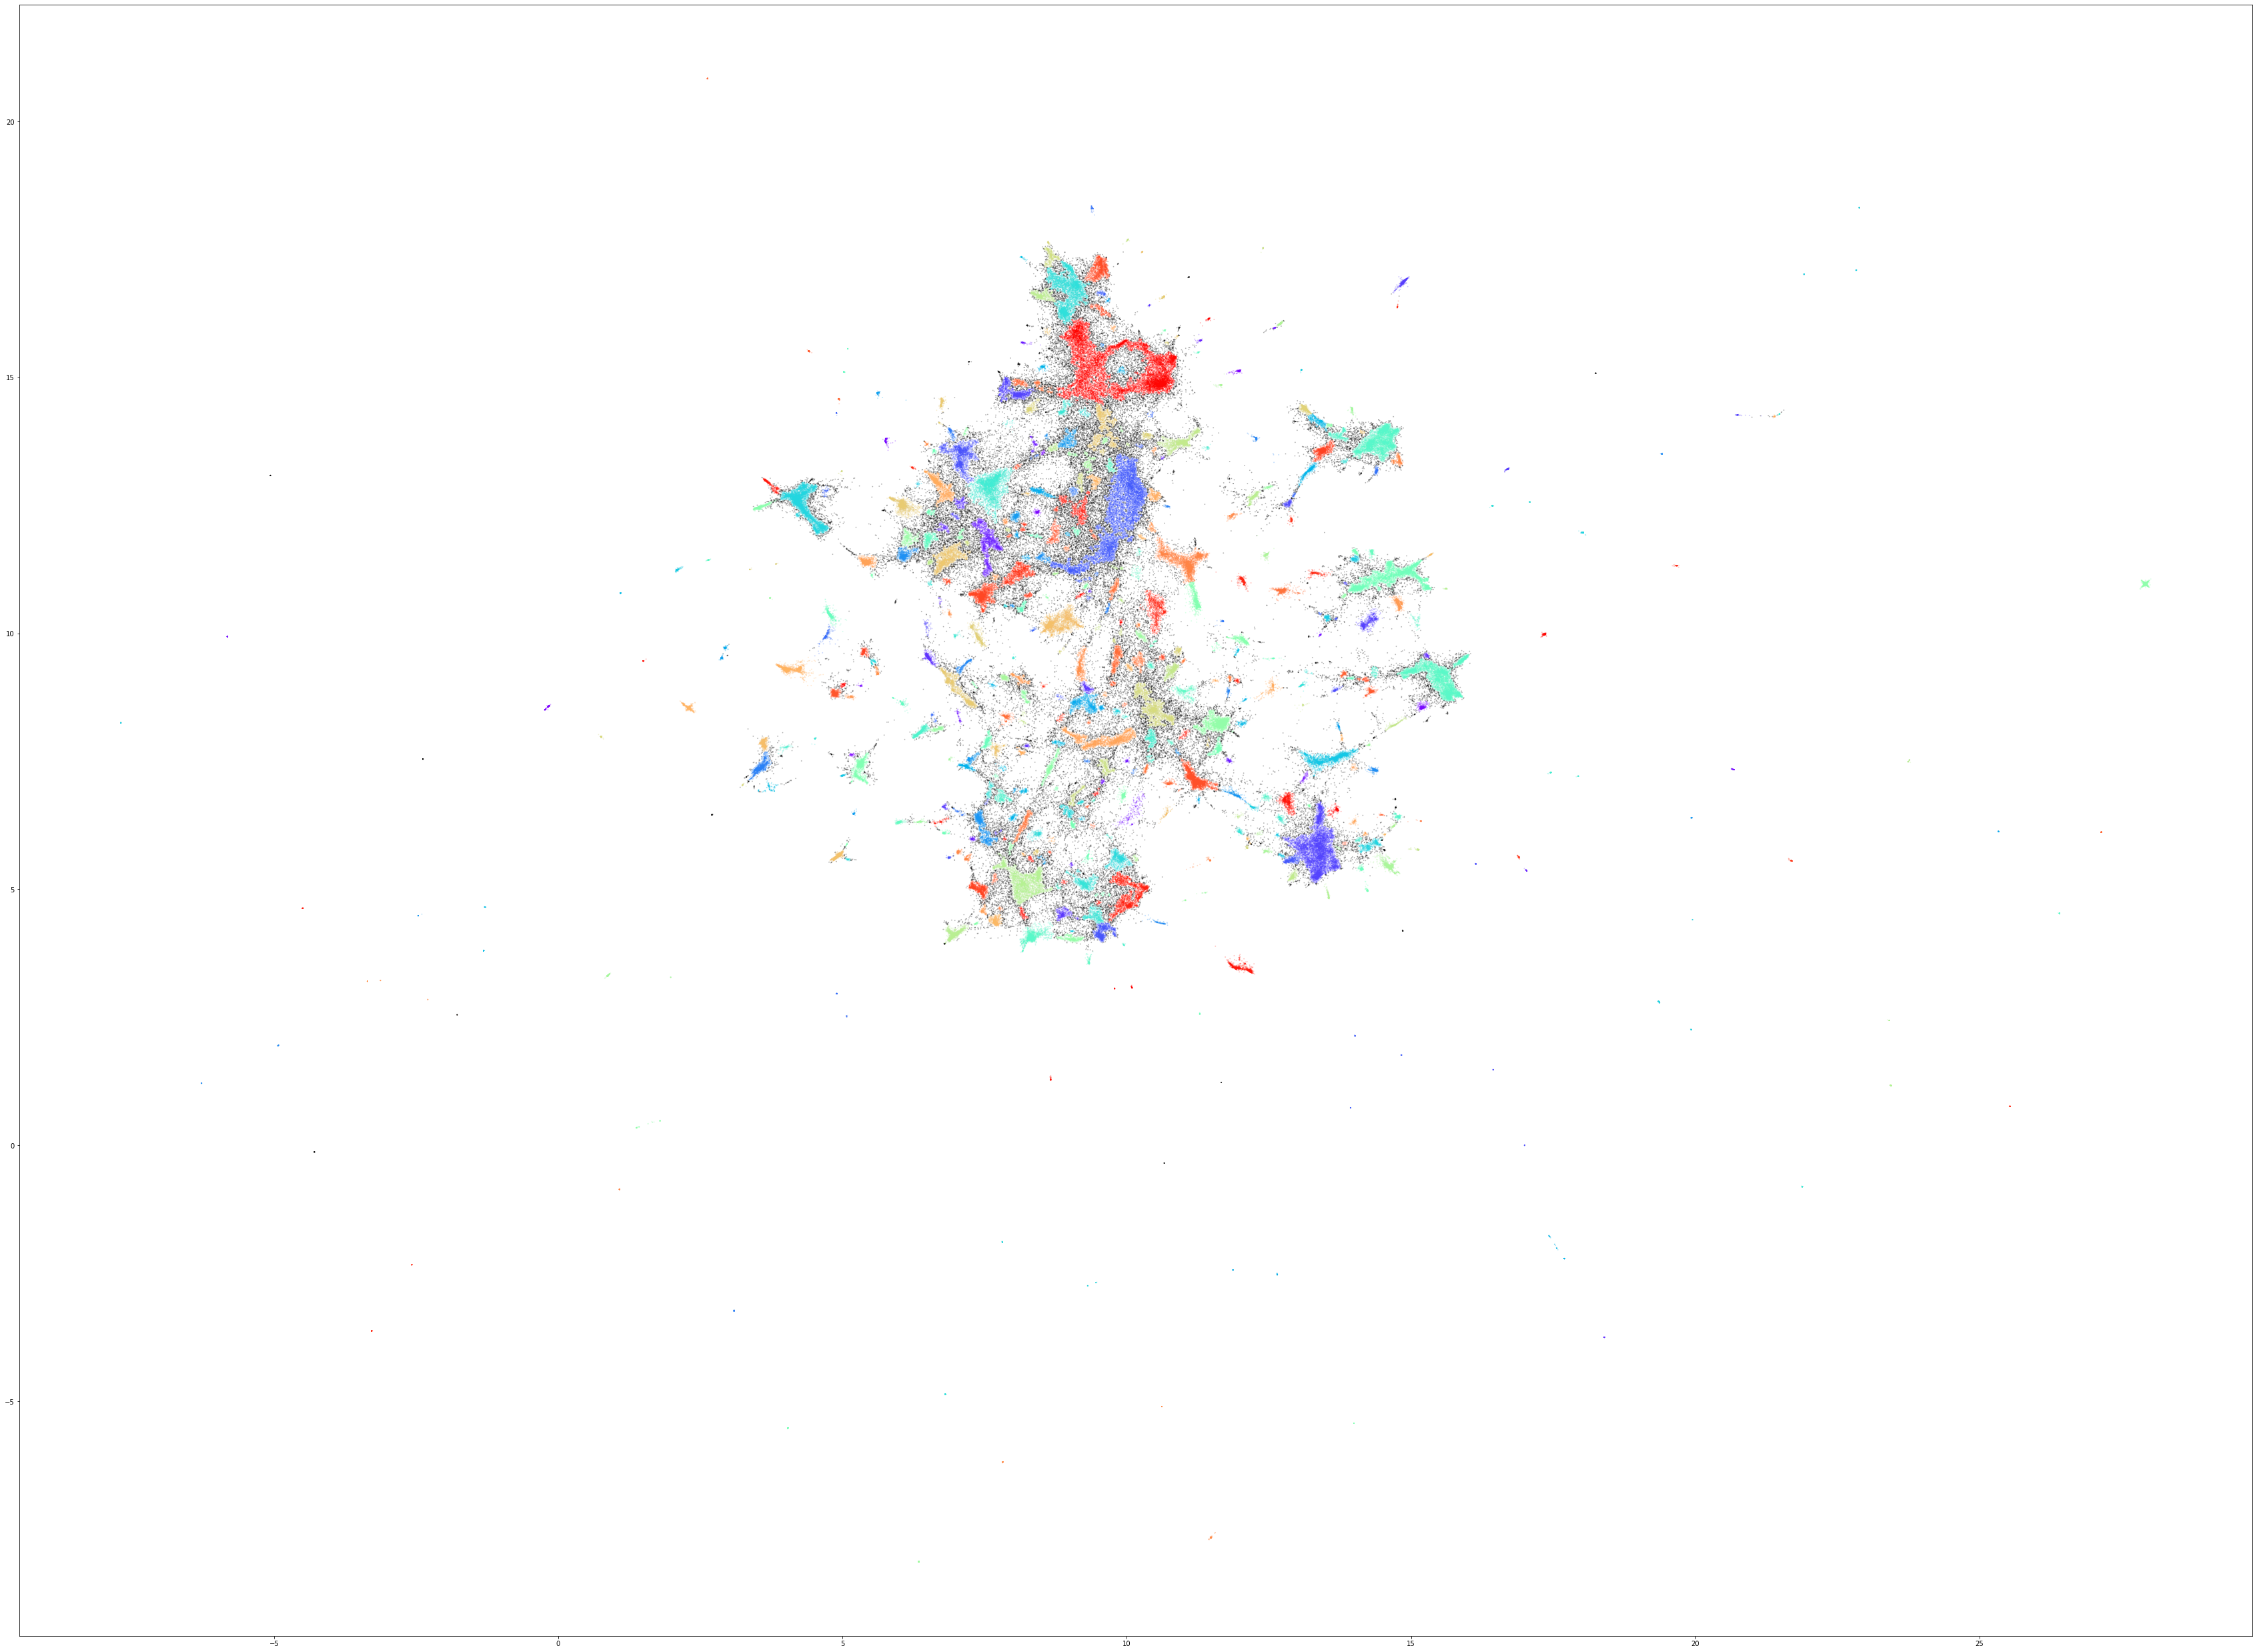

In [309]:
cmap = plt.get_cmap('rainbow')
cmap.set_under('black')  # Color for values less than vmin

plt.figure(figsize=(60,45))
plt.scatter(X[:,0], X[:,1], 
            s=1, alpha=.2, c=cluster_labels,
            cmap=cmap, vmin=0)#, edgecolors='k', linewidth=0)
plt.savefig('pp-mpnet-bv2-pca400-nn15-md0-cosine_hdbscan3.png', dpi=200)
plt.show()

## analyse clusters

In [311]:
cluster_sizes = Counter(cluster_labels)

In [313]:
print(cluster_sizes.most_common()[:10])
print('\r')
print(cluster_sizes.most_common()[-10:])

[(-1, 54782), (501, 13161), (60, 9553), (45, 7465), (217, 5894), (239, 5200), (212, 5040), (162, 4865), (172, 4672), (190, 3456)]

[(287, 22), (26, 22), (25, 22), (293, 21), (52, 21), (449, 20), (69, 20), (164, 20), (438, 20), (361, 20)]


In [314]:
t = 200
clusters_over_t = [x[0] for x in cluster_sizes.most_common() if x[1]>=t]

n = 5
ids = np.random.choice(clusters_over_t, n, replace=False)
sample = [(x, cluster_sizes[x]) for x in ids]
for x in sample:
    print(x)

(102, 1290)
(108, 341)
(203, 347)
(36, 440)
(392, 1907)


In [128]:
nlp = spacy.load("en_core_web_sm")

In [315]:
cluster_id = 102
speech_ids = np.where(cluster_labels == cluster_id)
cluster_rows = df.iloc[speech_ids]

cluster_word_freq = Counter(" ".join(cluster_rows.speech.values).split()).most_common()
cluster_nonstopword_freq = [x for x in cluster_word_freq if nlp.vocab[x[0].lower()].is_stop == False and nlp.vocab[x[0]].is_alpha == True]

cluster_heading_word_freq = Counter(cluster_rows.reset_index().heading.str.lower().str.split().apply(pd.Series).stack().values).most_common()
cluster_heading_nonstopword_freq = [x for x in cluster_heading_word_freq if nlp.vocab[x[0].lower()].is_stop == False and nlp.vocab[x[0]].is_alpha == True]

In [316]:
cluster_heading_nonstopword_freq[:10]

[('development', 654),
 ('international', 570),
 ('topical', 212),
 ('questions', 212),
 ('commonwealth', 173),
 ('foreign', 167),
 ('office', 161),
 ('aid', 140),
 ('business', 99),
 ('house', 75)]

In [317]:
cluster_nonstopword_freq[:25]

[('Government', 1158),
 ('people', 1135),
 ('aid', 1051),
 ('right', 1004),
 ('Friend', 940),
 ('work', 754),
 ('development', 747),
 ('support', 736),
 ('countries', 698),
 ('UK', 686),
 ('Secretary', 679),
 ('international', 667),
 ('Minister', 665),
 ('need', 560),
 ('State', 521),
 ('important', 519),
 ('money', 499),
 ('Member', 495),
 ('humanitarian', 490),
 ('DFID', 465),
 ('ensure', 465),
 ('country', 429),
 ('Department', 424),
 ('Gentleman', 417),
 ('House', 400)]

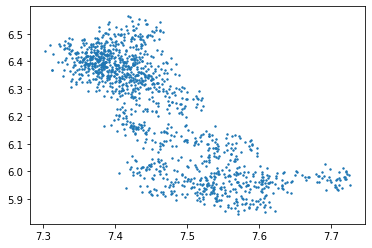

In [323]:
X_cluster = X[np.where(cluster_labels == cluster_id)[0]]
plt.scatter(X_cluster[:,0], X_cluster[:,1], s=2)

## plot centroid of each cluster

In [330]:
df_proj = pd.DataFrame(X)
df_proj['cluster'] = cluster_labels

In [357]:
df_clusters = df_proj.groupby('cluster').agg({0: ['mean'], 1: ['mean'], 'cluster':[len]})

In [378]:
X_centroids = df_clusters[[0,1]].values[1:]
cluster_size = df_clusters['cluster'].values[1:]

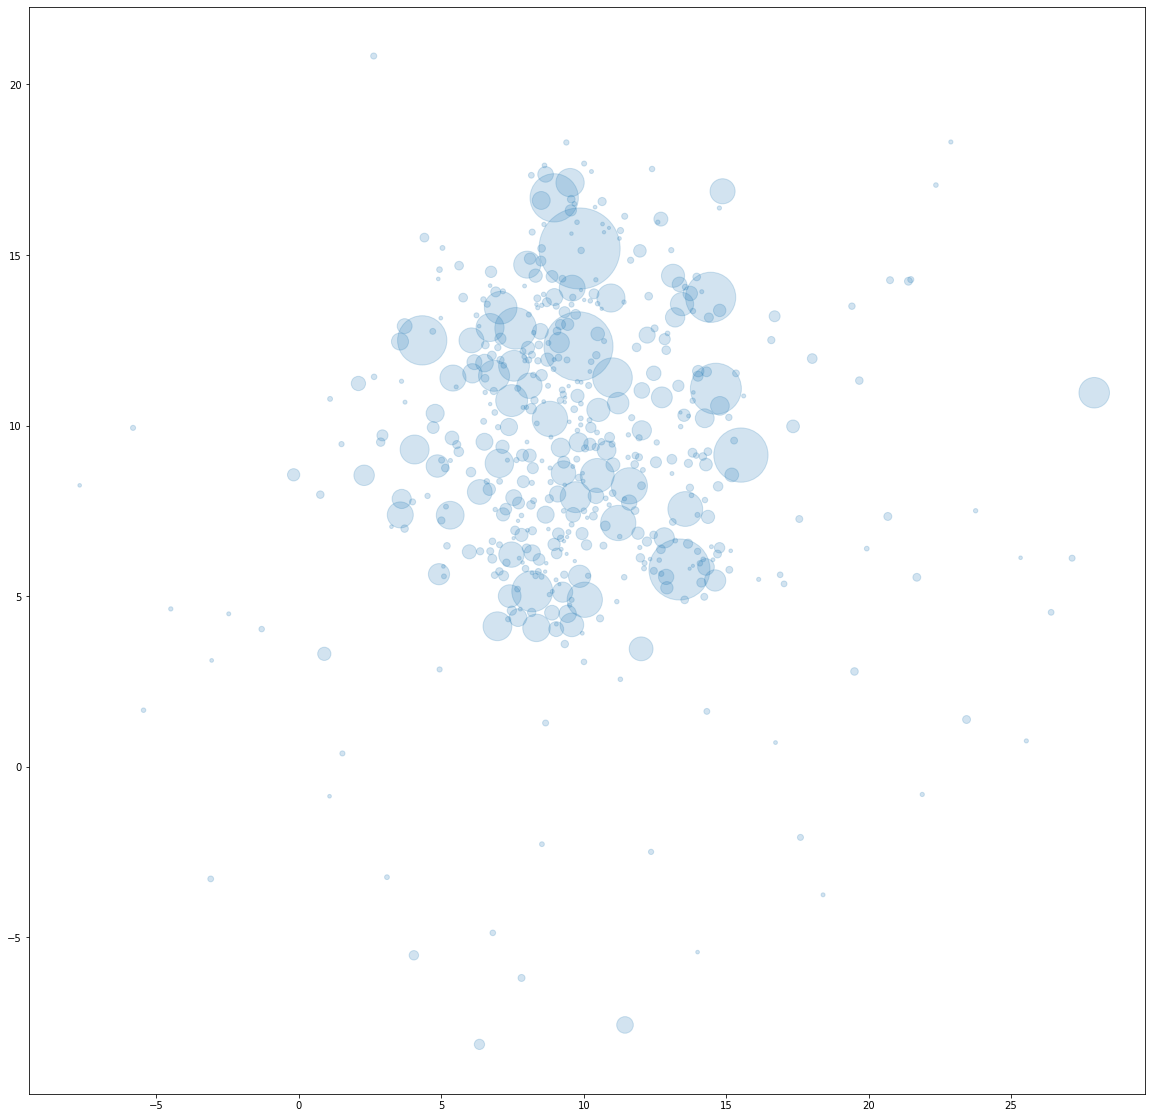

In [379]:
plt.figure(figsize=(20,20))
plt.scatter(X_centroids[:,0], X_centroids[:,1], s=cluster_size/2, alpha=0.2)